## Verrijkte kleinverbruikergegevens
Creer een nieuwe dataset obv de NEDU profielen en de kleinverbruikergegevens. De nieuwe dataset bevat dan het kleinverbruik per dag per postcode.

De stappen die genomen worden zijn:

1. Inlezen h5 bestanden met de NEDU profielen en kleinverbruikergegevens
2. Voeg profiel toe aan kleinverbruikergegevens
3. Transformeer NEDU profielen set tot een verbruik per dag ipv verbruik per kwartier
4. Nieuw dataframe opbouwen met per dag de volgende data:
* Datum
* Verbruik
* Postcode
* Aantal aansluitingen

Om het juiste profiel te bepalen nemen we 2 dingen mee:
* Wat is percentage meters met een Laag/Hoog tarief. Als dit percentage lager is dan 30% wordt het gebied in een A profiel gezet.
* Ligt het gebied in Noord of Zuid-Nederland. Dit wordt gebruikt om te bepalen of het gebied een E1B of E1C profiel krijgt.

Het verbruik wordt berekend door het verbruik van het profiel behorende bij de postcode te sommeren voor een dag.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# show all columns in the dataframe
pd.set_option('max_columns', None)

In [2]:
os.getcwd()

'C:\\Users\\MarcelKoolwijk\\Documents\\SQL\\jads_enexis\\notebooks'

In [3]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_verbruik = pd.read_hdf('kleinverbruikgegevens_data.h5')

# NEDU profielen
df_nedu_profielen = pd.read_hdf('nedu_files.h5')
df_transform_nedu = pd.read_hdf('nedu_files_transformed.h5')

# mapping van PC4 buurt naar RES regio
df_pc4_res = pd.read_hdf('pc4_res.h5')

In [4]:
# Laat alle soorten aansluitingen zien
df_verbruik.SOORT_AANSLUITING.unique()

array(['1X25', '3X25', '1X35', '3X35', '3X63', '1X40', '3X80', '3X50',
       '1X20', '3X40', '1x25', '3x25', '1x35', '1x40', '3x35', '3x63',
       '3x80', '3x50', '3x40', '1x20'], dtype=object)

In [5]:
provincie_limburg = ['61', '62', '63', '64']
provincie_brabant = ['42', '46', '47', '48', '49', '50', '51', '52', '53', '44', '55', '56', '57', '58', '60', '97']
profiel_E1 = ['1X25','3X25', '1X20'] # de rest is profiel E2

# Voeg in de kleinverbruikgegevens, het bijpassende profiel voor de soort aansluiting toe
def vervang_door_profiel(aansluiting, postcode, percentage):
    # Bepaal basisprofiel
    profiel = 'E1' if aansluiting in profiel_E1 else 'E2'

    # Een laag tarief percentage lager dan 30% zetten we in een A profiel
    lh_profiel = 'A' if percentage < 30 else 'B'

    # Bepaal welk laag tarief gebied de postcode zit
    if profiel == 'E1' and lh_profiel == 'B':
        postcode_area = postcode[:2] # PC4
        if postcode_area in provincie_brabant or postcode_area in provincie_limburg:
            lh_profiel = 'C'
    return profiel + lh_profiel

df_verbruik["PROFIEL"] = np.vectorize(vervang_door_profiel)(df_verbruik.SOORT_AANSLUITING, df_verbruik.POSTCODE_VAN, df_verbruik.SJV_LAAG_TARIEF_PERC)
df_verbruik.head()

,NETBEHEERDER,NETGEBIED,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,LANDCODE,PRODUCTSOORT,VERBRUIKSSEGMENT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,FYSIEKE_STATUS_PERC,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,JAAR,PC4,SJV_TOTAAL,PROFIEL
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,KVB,100.0,16,100,0.0,1X25,4282.0,25.0,0.0,2010,4251,69.0,E1A
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,NL,ELK,KVB,100.0,11,100,0.0,1X25,5113.0,10.0,0.0,2010,4251,56.0,E1A
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,NL,ELK,KVB,100.0,30,100,0.0,3X25,4809.0,34.0,0.0,2010,4251,144.0,E1C
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,NL,ELK,KVB,100.0,21,100,0.0,1X25,5015.0,44.0,0.0,2010,4251,105.0,E1C
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,NL,ELK,KVB,100.0,12,100,0.0,1X25,3074.0,22.0,0.0,2010,4251,37.0,E1A


In [6]:
from datetime import datetime
import math

# Voeg een datum kolom toe zodat we kunnen aggreren per datum per profiel
def haal_datum_op(datum):
    datum = pd.to_datetime(datum)
    # Laatste rij is blijkbaar NaN. 
    if math.isnan(datum.year):
        return ''
    return datetime(datum.year,datum.month,datum.day)
df_nedu_profielen["DATUM"] = np.vectorize(haal_datum_op)(df_nedu_profielen.Start)

# Groepeer op datum en sommeer de profielen die we nodig hebben
df_nedu_gereduceerd = df_nedu_profielen.groupby('DATUM').agg({'E1A':'sum', 'E1B':'sum', 'E1C':'sum', 'E2A':'sum', 'E2B':'sum'})

# Sorteer op datum
df_nedu_gereduceerd = df_nedu_gereduceerd.sort_values(by='DATUM')
print (f"Aantal rijen in de NEDU set = {df_nedu_gereduceerd.shape[0]}")

# Check de eerste paar rijen.
df_nedu_gereduceerd.head()

Aantal rijen in de NEDU set = 4383


,E1A,E1B,E1C,E2A,E2B
DATUM,,,,,
2010-01-01,0.003261,0.003344,0.003464,0.001992,0.002531
2010-01-02,0.003144,0.003115,0.003006,0.003491,0.003126
2010-01-03,0.003003,0.002898,0.002952,0.003190,0.002986
2010-01-04,0.002622,0.002546,0.002759,0.003222,0.002895
2010-01-05,0.002518,0.002503,0.002419,0.001884,0.002260


# Test dataframe voor 1 PC4

In [7]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# df_transform_nedu = pd.DataFrame(columns=["DATUM", "PROFIEL", "VERBRUIKS_FACTOR"])
# for index,row in df_nedu_gereduceerd.iterrows():
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1A", "VERBRUIKS_FACTOR":row.E1A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1B", "VERBRUIKS_FACTOR":row.E1B}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1C", "VERBRUIKS_FACTOR":row.E1C}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2A", "VERBRUIKS_FACTOR":row.E2A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2B", "VERBRUIKS_FACTOR":row.E2B}, ignore_index=True)

# # we voegen er nog een jaar aan toe om met verbuik dataset te kunnen joinen
# df_transform_nedu['JAAR'] = df_transform_nedu['DATUM'].dt.year

# df_transform_nedu.head()

In [8]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# data_processed_location = '../data/processed'

# if 'processed' not in os.getcwd():
#     os.chdir(data_processed_location)

# try:
#     os.remove('nedu_files_transformed.h5')
# except:
#     print ('File nog in gebruik of niet gevonden')

# store = pd.HDFStore('nedu_files_transformed.h5')
# store['nedu_files_transformed'] = df_transform_nedu
# store.close()

In [10]:
# RES toevoegen aan vebruik dataframe
df_verbruik['PC4'] = df_verbruik['PC4'].astype('int64')
df_verbruik = pd.merge(df_verbruik, df_pc4_res, on=['PC4'], how='left')

In [13]:
# een sample nemen uit de verbruiks data 
# en deze joinen met de df_transform_nedu data
df_sample = df_verbruik[['RES','PC4','JAAR','SJV_TOTAAL','PROFIEL']][df_verbruik['PC4'] == 5211]
df_sample = pd.merge(df_sample, df_transform_nedu, on=['JAAR','PROFIEL'], how='left')

# verbruik per dag berekenen
df_sample['VERBRUIK'] =  df_sample['SJV_TOTAAL'] * df_sample['VERBRUIKS_FACTOR']

# df_verbruik is nog per pc6, dus eerst omzetten naar pc4
df_sample_pc4 = df_sample.groupby(['RES','PC4','DATUM'], as_index=False).agg(VERBRUIK = ('VERBRUIK', 'sum'))
df_sample_pc4 = pd.DataFrame(df_sample_pc4[['DATUM','VERBRUIK']]).set_index('DATUM')
df_sample_pc4.head()

,VERBRUIK
DATUM,
2010-01-01,137.348759
2010-01-02,149.213090
2010-01-03,143.229917
2010-01-04,136.805796
2010-01-05,109.593468


In [16]:
df_sample_pc4.index.year.value_counts()

2012    366
2016    366
2020    366
2013    365
2017    365
2021    365
2010    365
2014    365
2018    365
2011    365
2015    365
2019    365
Name: DATUM, dtype: int64

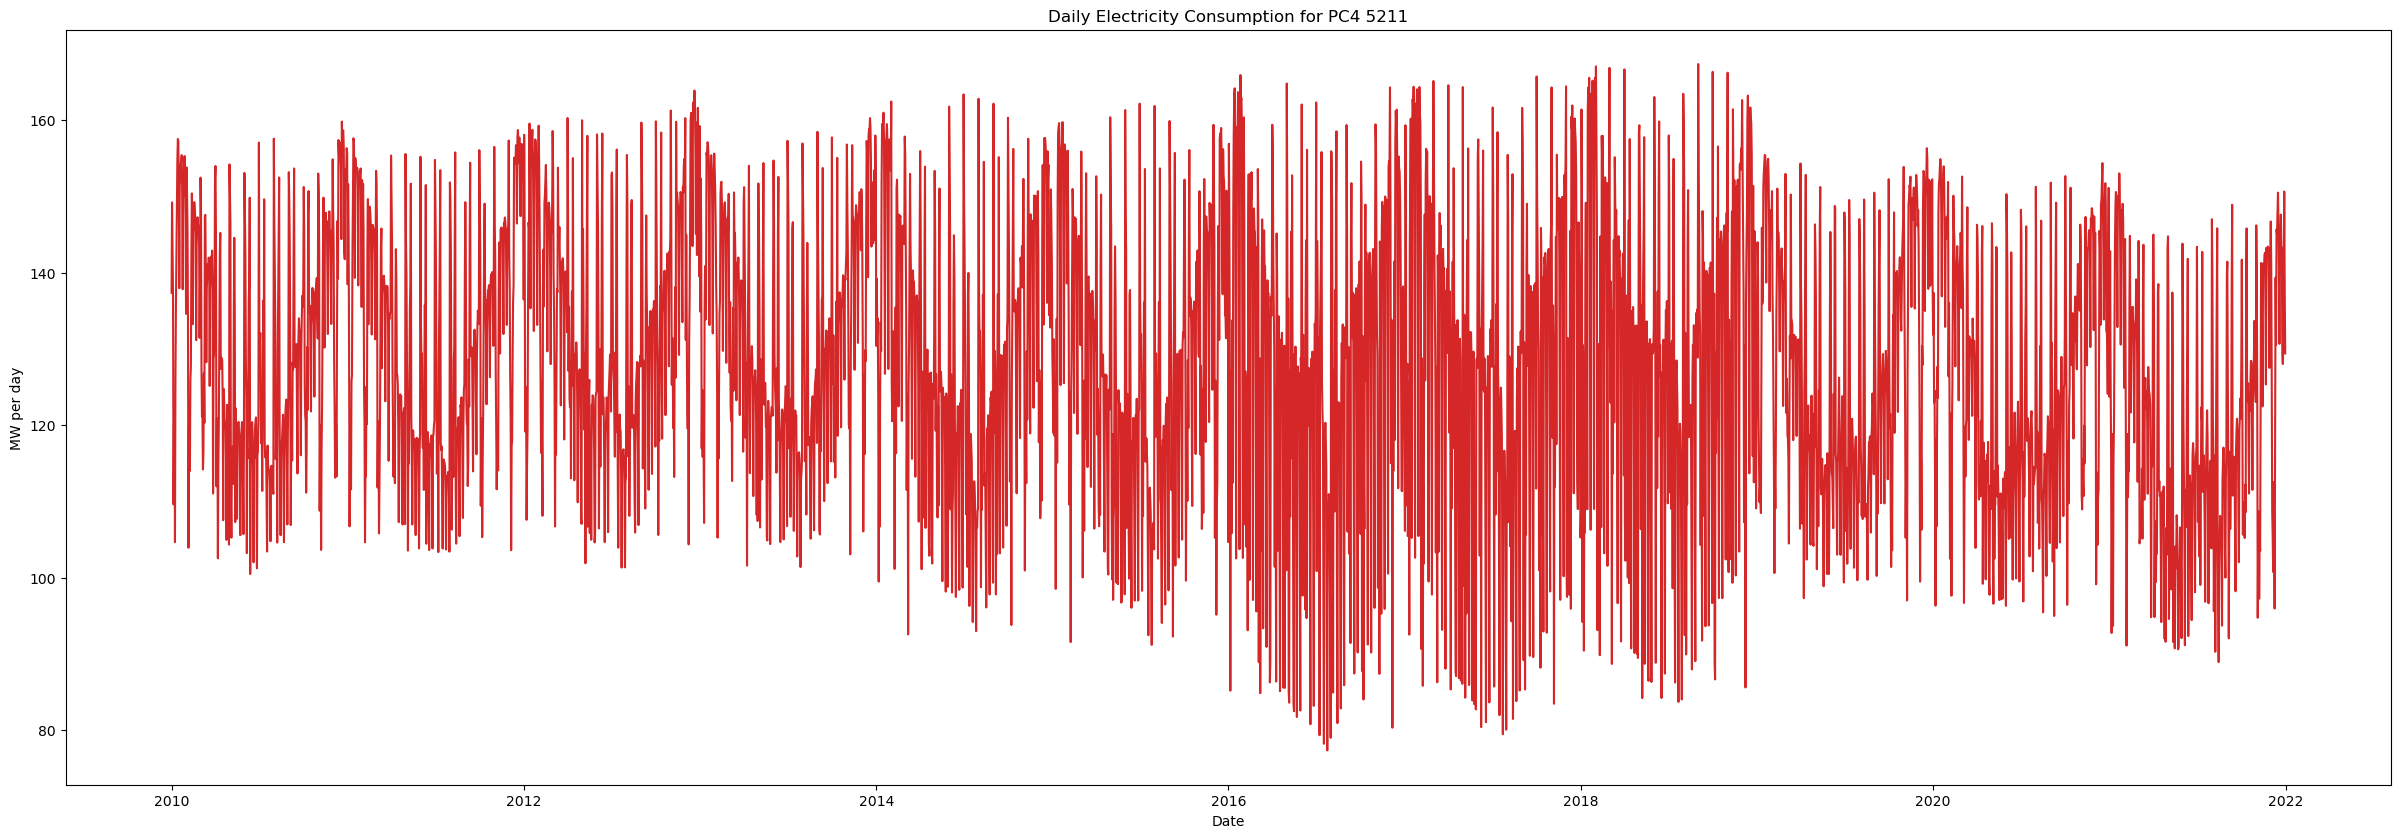

In [22]:
# Time series plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='MW per day', dpi=100):
    plt.figure(figsize=(30,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_sample_pc4, x=df_sample_pc4.index, y=df_sample_pc4['VERBRUIK'], title='Daily Electricity Consumption for PC4 5211')  

In [23]:
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

try:
    os.remove('pc4_verbruiksdata_per_dag_5211.h5')
except:
    print ('File nog in gebruik of niet gevonden')

store = pd.HDFStore('pc4_verbruiksdata_per_dag_5211.h5')
store['pc4_verbruiksdata_per_dag_5211'] = df_sample_pc4
store.close()

# Einde Test dataframe voor 1 PC4

In [ ]:
# Manier 1. Eerst aantal rijen reduceren tot PC4 en daarna NEDU data invoegen. Wat doen we dan met het profiel?
print (f"Aantal rijen voor reductie = {df_verbruik.shape[0]}")

# groepeer de kleinverbruiker gegevens op PC4 level. Om het gemiddelde profiel te bepalen maken we een custom functie 'bepaal_profiel', die de profielen telt
def bepaal_profiel(series):
    profielen = series.value_counts()

    e1_counts = e2_counts = 0
    for index, value in profielen.items():
        if index[:2] == 'E1':
            e1_counts = e1_counts + value
        else:
            e2_counts = e2_counts + value
    #print (e1_counts, e2_counts)
#profiel = profielen[profielen == max(profielen)].index.values[0]            
    return 'E1B' if e1_counts > e2_counts else 'E2B'

df_verbruik_gereduceerd = df_verbruik.groupby('PC4').agg({'PROFIEL':bepaal_profiel, 'SJV_GEMIDDELD':'sum', 'AANSLUITINGEN_AANTAL':'sum', 'LEVERINGSRICHTING_PERC': 'mean'})

print(f"Aantal rijen na reductie = {df_verbruik_gereduceerd.shape[0]}")

print(f"Aantal E1 profielen = {df_verbruik_gereduceerd[df_verbruik_gereduceerd.PROFIEL == 'E1B'].shape[0]}")
print(f"Aantal E2 profielen = {df_verbruik_gereduceerd[df_verbruik_gereduceerd.PROFIEL == 'E2B'].shape[0]}")

df_verbruik_gereduceerd.head()

In [ ]:
# Manier 2. We maken een dictionary van postcode naar {#aansluitingen, dateframe met NEDU profiel data} en zetten die om naar een dataframe

# Testje met een minimale dictionary
data = { 'POSTCODE': '4251AB', 'AANSLUITINGEN_AANTAL' : 10, 'LEVERINGSRICHTING_PERC' : 34, 'VERBRUIK': {'2010-01-01': 12, '2010-01-02': 15}}
pd.DataFrame.from_dict(data)

In [ ]:
# Manier 3. We gebruik de merge methode van pandas. We proberen te mergen op profiel. Hiervoor moet het profielen dataframe wel van structuur veranderen
# Structuur moet worden datum, profiel, verbruik. Dan kunnen we op Profiel proberen te mergen.

# Dit kan vast sneller met een goede pivot of eerst een dictionary opbouwen maar het werkt
df_transform_nedu = pd.DataFrame(columns=["Datum", "Profiel", "Verbruik"])
for index,row in df_nedu_gereduceerd.iterrows():
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1A", "Verbruik":row.E1A}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1B", "Verbruik":row.E1B}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1C", "Verbruik":row.E1C}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E2A", "Verbruik":row.E2A}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E2B", "Verbruik":row.E2B}, ignore_index=True)
df_transform_nedu

In [ ]:
df_transform_nedu['Verbruik'].sum()

In [ ]:
import time

# Build a frame per PC4
print ("Lijst met PC4 codes samenstellen", end="..")
PC4_list = df_verbruik.PC4.unique()
pc4_count = len(PC4_list)
print (f"done. Er zijn {pc4_count} pc4 codes")

# First PC4 area in de lijst
first_pc4 = PC4_list[0]

# Schrijf het samengevoegde dataframe naar een bestand
def write_h5(df):
    file = f"pc4_verbruiksdata"

    # Haal een eventuele vorige versie weg
    try:
        os.remove(file + '.h5')
    except:
        # Schrijf het bestand weg
        store = pd.HDFStore(file + '.h5')
        store[file] = df
        store.close()

# Gebruik data van 1 jaar. Anders krijgen we te veel
print ("Filter kleinverbruik data voor 2020", end="..")
df_verbruik = df_verbruik[df_verbruik.JAAR == 2020]
print (f"done")

# Per pc4 area maak een samengevoegd dataframe
i = 1
df_end_frame = None
def do_per_pc4(pc4):
    global i, df_end_frame
    start = time.time()

    print(f'{format(i,"04d")}. Samenvoegen profielen en verbruiksdata voor {pc4}', end = '..')
    i = i + 1

    # Maak kleiner frame
    df_verbruik_pc4 = df_verbruik[df_verbruik.PC4 == pc4]
    
    # Voeg samen met de profielen set
    df_merge = pd.merge(df_verbruik_pc4, df_transform_nedu, left_on=['PROFIEL'], right_on=['Profiel'])

    # Pak alleen de kolommen die we willen hebben
    df_merge = df_merge[['Datum', 'JAAR', 'Verbruik', 'PC4', 'LEVERINGSRICHTING_PERC', 'AANSLUITINGEN_AANTAL', 'PROFIEL', 'SJV_GEMIDDELD', 'PROFIEL']]

    # rol op per pc4 gebied
    df_merge = df_merge.groupby(['Datum', 'PC4']).agg({'Verbruik': 'sum'})

    if df_end_frame is None:
        df_end_frame = df_merge.copy()
    else:
        df_end_frame = df_end_frame.append(df_merge)

    end = time.time()
    exec_tijd = format(end - start, '.1f')
    print(f'done in {exec_tijd}s')

    return df_merge

# Doe voor alle pc4 entries
for pc4 in PC4_list:
    do_per_pc4(pc4)

# Schrijf bestand weg
write_h5(df_end_frame)

In [ ]:
df_end_frame.head()

In [ ]:
df_end_frame.tail()

In [ ]:
df_end_frame.info()